the gdown lines are the dataset, training.odgt and validation.odgt in that order

In [ ]:
%%bash
# Colab-specific setup
!(stat -t /usr/local/lib/*/dist-packages/google/colab > /dev/null 2>&1) && exit 
pip install yacs 2>&1 >> install.log
pip install torchviz >> install.log
pip install gdown >> install.log
git init 2>&1 >> install.log
git remote add origin https://github.com/CSAILVision/semantic-segmentation-pytorch.git 2>> install.log
git pull origin master 2>&1 >> install.log
DOWNLOAD_ONLY=1 ./demo_test.sh 2>> install.log
wget http://sceneparsing.csail.mit.edu/model/pytorch/ade20k-resnet101-upernet/decoder_epoch_50.pth >> install.log
wget http://sceneparsing.csail.mit.edu/model/pytorch/ade20k-resnet101-upernet/encoder_epoch_50.pth >> install.log
rm data/training.odgt
rm data/validation.odgt

From https://github.com/CSAILVision/semantic-segmentation-pytorch
 * branch            master     -> FETCH_HEAD
 * [new branch]      master     -> origin/master


--2021-12-27 04:00:43--  http://sceneparsing.csail.mit.edu/model/pytorch/ade20k-resnet101-upernet/decoder_epoch_50.pth
Resolving sceneparsing.csail.mit.edu (sceneparsing.csail.mit.edu)... 128.30.195.26
Connecting to sceneparsing.csail.mit.edu (sceneparsing.csail.mit.edu)|128.30.195.26|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 162479372 (155M)
Saving to: ‘decoder_epoch_50.pth’

     0K .......... .......... .......... .......... ..........  0%  754K 3m30s
    50K .......... .......... .......... .......... ..........  0% 1.48M 2m37s
   100K .......... .......... .......... .......... ..........  0% 62.3M 1m46s
   150K .......... .......... .......... .......... ..........  0% 84.3M 80s
   200K .......... .......... .......... .......... ..........  0% 1.52M 84s
   250K .......... .......... .......... .......... ..........  0% 64.6M 70s
   300K .......... .......... .......... .......... ..........  0% 70.4M 61s
   350K .......... .......... .......... ...

In [ ]:
!gdown --id 175jNPAbVoLU_YW4cEVBoaDli5iITQ7wh
!unzip hdb.zip -d .
!mkdir data/hdb
!mkdir data/hdb/images
!mkdir ckpt/ade20k-resnet101-upernet
#gdown --id 1vJxPY1EJNuL5LZbOnPCHvf7XdzUp7Rf-
#gdown --id 1JxHfcIfni3vzsjDQehKsUrpKhuSfWzso
#unzip ade20k.zip
#mkdir data/ade20k
#mkdir data/ade20k/images
#mv images/training data/ade20k/images/training
#mv images/validation data/ade20k/images/validation
#mv training.odgt data/training.odgt
#mv validation.odgt data/validation.odgt

Downloading...
From: https://drive.google.com/uc?id=175jNPAbVoLU_YW4cEVBoaDli5iITQ7wh
To: /content/hdb.zip
100% 42.1M/42.1M [00:00<00:00, 159MB/s]
Archive:  hdb.zip
   creating: ./hdb/images/
   creating: ./hdb/images/training/
   creating: ./hdb/images/training/annotations/
  inflating: ./hdb/images/training/annotations/1019_1.333428+103.7222518_temp_-0_00_-115_97_0_00_-8_27_-12_01_28_99.png  
  inflating: ./hdb/images/training/annotations/1019_1.333428+103.7222518_temp_105_30_-42_73_23_15_-8_27_-12_01_28_99.png  
  inflating: ./hdb/images/training/annotations/1019_1.333428+103.7222518_temp_-107_05_6_10_44_19_-8_27_-12_01_28_99.png  
  inflating: ./hdb/images/training/annotations/1019_1.333428+103.7222518_temp_107_57_18_31_39_28_-8_27_-12_01_28_99.png  
  inflating: ./hdb/images/training/annotations/1019_1.333428+103.7222518_temp_36_71_-103_76_36_53_-8_27_-12_01_28_99.png  
  inflating: ./hdb/images/training/annotations/1019_1.333428+103.7222518_temp_-38_19_103_76_34_99_-8_27_-12_01_2

In [ ]:
!mv hdb/images/training data/hdb/images/training
!mv hdb/images/validation data/hdb/images/validation
!mv hdb/training.odgt data/training.odgt
!mv hdb/validation.odgt data/validation.odgt

In [ ]:
# System libs
import os
import time
# import math
import random
import argparse
from distutils.version import LooseVersion
# Numerical libs
import torch
import torch.nn as nn
# Our libs
from mit_semseg.config import cfg
from mit_semseg.dataset import TrainDataset
from mit_semseg.models import ModelBuilder, SegmentationModule
from mit_semseg.utils import AverageMeter, parse_devices, setup_logger
from mit_semseg.lib.nn import UserScatteredDataParallel, user_scattered_collate, patch_replication_callback

In [ ]:
root_dataset = "./data/"
list_train = "./data/training.odgt"
list_val = "./data/training.odgt"
num_class = 4
padding_constant = 32
segm_downsampling_rate = 4
random_flip = True
arch_encoder="resnet101"
arch_decoder="upernet"
fc_dim=2048
weights_encoder = "encoder_epoch_50.pth"
weights_decoder = "decoder_epoch_50.pth"
batch_size_per_gpu = 2
num_epoch = 3
start_epoch = 0
epoch_iters = 50
optim = "SGD"
lr_encoder = 0.02
lr_decoder = 0.02
lr_pow = 0.9
beta1 = 0.9
weight_decay = 1e-4
deep_sup_scale = 0.4
fix_bn = False
workers = 2
disp_iter = 1
seed = 304
running_lr_encoder = ""
running_lr_encoder = ""
class dataset_custom:
  def __init__(self):
    self.imgSizes = (300, 375, 450, 525, 600)
    self.imgMaxSize = 1000
    self.padding_constant = 32
    self.segm_downsampling_rate = 4
trained_dataset = dataset_custom()
DIR = "ckpt/ade20k-resnet101-upernet"

In [ ]:
def checkpoint(nets, history, epoch):
    print('Saving checkpoints...')
    (net_encoder, net_decoder, crit) = nets

    dict_encoder = net_encoder.state_dict()
    dict_decoder = net_decoder.state_dict()

    torch.save(
        history,
        '{}/history_epoch_{}.pth'.format(DIR, epoch))
    torch.save(
        dict_encoder,
        '{}/encoder_epoch_{}.pth'.format(DIR, epoch))
    torch.save(
        dict_decoder,
        '{}/decoder_epoch_{}.pth'.format(DIR, epoch))

In [ ]:
def create_optimizers(nets):
    (net_encoder, net_decoder, crit) = nets
    '''
    optimizer_encoder = torch.optim.SGD(
        filter(lambda p: p.requires_grad, net_encoder.parameters()),
        lr=lr_encoder,
        momentum=beta1)
    '''
    optimizer_decoder = torch.optim.SGD(
        filter(lambda p: p.requires_grad, net_decoder.parameters()),
        lr=lr_decoder,
        momentum=beta1)
    return (0, optimizer_decoder)

In [ ]:
def adjust_learning_rate(optimizers, cur_iter):
    scale_running_lr = ((1. - float(cur_iter) / max_iters) ** lr_pow)
    running_lr_encoder = lr_encoder * scale_running_lr
    running_lr_decoder = lr_decoder * scale_running_lr

    (optimizer_encoder, optimizer_decoder) = optimizers
    for param_group in optimizer_decoder.param_groups:
        param_group['lr'] = running_lr_decoder

In [ ]:
def train(segmentation_module, iterator, optimizers, history, epoch):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    ave_total_loss = AverageMeter()
    ave_acc = AverageMeter()

    segmentation_module.train(not fix_bn)

    # main loop
    tic = time.time()
    for i in range(epoch_iters):
        # load a batch of data
        batch_data = next(iterator)
        data_time.update(time.time() - tic)
        segmentation_module.zero_grad()

        # adjust learning rate
        cur_iter = i + (epoch - 1) * epoch_iters
        adjust_learning_rate(optimizers, cur_iter)

        # forward pass
        loss, acc = segmentation_module(batch_data[0])
        loss = loss.mean()
        acc = acc.mean()

        # Backward
        loss.backward()
        for optimizer in optimizers:
          if(optimizer != 0):
            optimizer.step()

        # measure elapsed time
        batch_time.update(time.time() - tic)
        tic = time.time()

        # update average loss and acc
        ave_total_loss.update(loss.data.item())
        ave_acc.update(acc.data.item()*100)

        # calculate accuracy, and display
        if i % disp_iter == 0:
            print('Epoch: [{}][{}/{}], Time: {:.2f}, Data: {:.2f}, '
                  'lr_encoder: {:.6f}, lr_decoder: {:.6f}, '
                  'Accuracy: {:4.2f}, Loss: {:.6f}'
                  .format(epoch, i, epoch_iters,
                          batch_time.average(), data_time.average(),
                          running_lr_encoder, running_lr_decoder,
                          ave_acc.average(), ave_total_loss.average()))

            fractional_epoch = epoch - 1 + 1. * i / epoch_iters
            history['train']['epoch'].append(fractional_epoch)
            history['train']['loss'].append(loss.data.item())
            history['train']['acc'].append(acc.data.item())

In [ ]:
def main(gpus):
    # Network Builders
    net_encoder = ModelBuilder.build_encoder(
        arch=arch_encoder.lower(),
        fc_dim=fc_dim,
        weights=weights_encoder)
    net_decoder = ModelBuilder.build_decoder(
        arch=arch_decoder.lower(),
        fc_dim=fc_dim,
        num_class=150, #150 Classes in original ADE20K Model
        weights=weights_decoder)

    crit = nn.NLLLoss(ignore_index=-1)

    
    segmentation_module = SegmentationModule(net_encoder, net_decoder, crit)
    segmentation_module.decoder.conv_last[1] = nn.Conv2d(512, num_class, kernel_size=(1, 1), stride=(1, 1))
    for params in segmentation_module.parameters():
      params.requires_grad = False
    segmentation_module.decoder.conv_last[0][0].weight.requires_grad = True # this layer does not have a bias
    segmentation_module.decoder.conv_last[0][1].weight.requires_grad = True
    segmentation_module.decoder.conv_last[0][1].bias.requires_grad = True

    segmentation_module.decoder.conv_last[1].weight.requires_grad = True
    segmentation_module.decoder.conv_last[1].bias.requires_grad = True

    # Dataset and Loader
    dataset_train = TrainDataset(
        root_dataset,
        list_train,
        trained_dataset,
        batch_per_gpu=batch_size_per_gpu)
    
    print("so far so good")

    loader_train = torch.utils.data.DataLoader(
        dataset_train,
        batch_size=len(gpus),  # we have modified data_parallel
        shuffle=False,  # we do not use this param
        collate_fn=user_scattered_collate,
        num_workers=workers,
        drop_last=True,
        pin_memory=True)
    print('1 Epoch = {} iters'.format(epoch_iters))

    # create loader iterator
    iterator_train = iter(loader_train)

    # load nets into gpu
    if len(gpus) > 1:
        segmentation_module = UserScatteredDataParallel(
            segmentation_module,
            device_ids=gpus)
        # For sync bn
        patch_replication_callback(segmentation_module)

    # Set up optimizers
    nets = (net_encoder, net_decoder, crit)
    optimizers = create_optimizers(nets)

    # Main loop
    history = {'train': {'epoch': [], 'loss': [], 'acc': []}}

    for epoch in range(start_epoch, num_epoch):
        train(segmentation_module, iterator_train, optimizers, history, epoch+1)

        # checkpointing
        checkpoint(nets, history, epoch+1)

    print('Training Done!')

    return segmentation_module

In [ ]:
gpus = parse_devices("0")
gpus = [x.replace('gpu', '') for x in gpus]
gpus = [int(x) for x in gpus]
num_gpus = len(gpus)
batch_size = num_gpus * batch_size_per_gpu

max_iters = epoch_iters * num_epoch
running_lr_encoder = lr_encoder
running_lr_decoder = lr_decoder

random.seed(seed)
torch.manual_seed(seed)

seg_module = main(gpus)

Loading weights for net_encoder
Loading weights for net_decoder
# samples: 1600
so far so good
1 Epoch = 50 iters
Epoch: [1][0/50], Time: 22.05, Data: 9.09, lr_encoder: 0.020000, lr_decoder: 0.020000, Accuracy: 26.91, Loss: 1.381200
Epoch: [1][1/50], Time: 27.58, Data: 4.55, lr_encoder: 0.020000, lr_decoder: 0.020000, Accuracy: 48.83, Loss: 1.240725
Epoch: [1][2/50], Time: 26.95, Data: 3.03, lr_encoder: 0.020000, lr_decoder: 0.020000, Accuracy: 59.74, Loss: 0.986130
Epoch: [1][3/50], Time: 26.69, Data: 2.27, lr_encoder: 0.020000, lr_decoder: 0.020000, Accuracy: 68.15, Loss: 0.814019
Epoch: [1][4/50], Time: 24.73, Data: 1.82, lr_encoder: 0.020000, lr_decoder: 0.020000, Accuracy: 72.93, Loss: 0.729434
Epoch: [1][5/50], Time: 24.95, Data: 1.52, lr_encoder: 0.020000, lr_decoder: 0.020000, Accuracy: 75.46, Loss: 0.725851
Epoch: [1][6/50], Time: 25.08, Data: 1.30, lr_encoder: 0.020000, lr_decoder: 0.020000, Accuracy: 78.15, Loss: 0.668196
Epoch: [1][7/50], Time: 25.19, Data: 1.14, lr_encoder

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# System libs
import os, csv, torch, numpy, scipy.io, PIL.Image, torchvision.transforms
# Our libs
from mit_semseg.models import ModelBuilder, SegmentationModule
from mit_semseg.utils import colorEncode

colors = scipy.io.loadmat('data/color150.mat')['colors']
names = {}
with open('data/object150_info.csv') as f:
    reader = csv.reader(f)
    next(reader)
    for row in reader:
        names[int(row[0])] = row[5].split(";")[0]

def visualize_result(img, pred, index=None):
    # filter prediction class if requested
    if index is not None:
        pred = pred.copy()
        pred[pred != index] = -1
        print(f'{names[index+1]}:')
        
    # colorize prediction
    pred_color = colorEncode(pred, colors).astype(numpy.uint8)

    # aggregate images and save
    #im_vis = numpy.concatenate((img, pred_color), axis=1)
    display(PIL.Image.fromarray(pred_color))

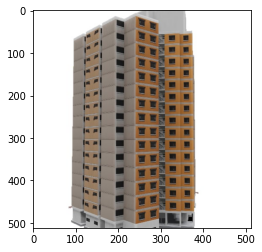

In [ ]:
# Load and normalize one image as a singleton tensor batch
pil_to_tensor = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(
        mean=[0.485, 0.456, 0.406], # These are RGB mean+std values
        std=[0.229, 0.224, 0.225])  # across a large photo dataset.
])
pil_image = PIL.Image.open('jesus.jpg').convert('RGB')
img_original = numpy.array(pil_image)
img_data = pil_to_tensor(pil_image)
singleton_batch = {'img_data': img_data[None].cuda()}
output_size = img_data.shape[1:]

import matplotlib.pyplot as plt
plt.imshow(img_original)

In [ ]:
seg_module.cuda()

SegmentationModule(
  (encoder): Resnet(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): SynchronizedBatchNorm2d(64, eps=1e-05, momentum=0.001, affine=True, track_running_stats=True)
    (relu1): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): SynchronizedBatchNorm2d(64, eps=1e-05, momentum=0.001, affine=True, track_running_stats=True)
    (relu2): ReLU(inplace=True)
    (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn3): SynchronizedBatchNorm2d(128, eps=1e-05, momentum=0.001, affine=True, track_running_stats=True)
    (relu3): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): SynchronizedBatchNorm2d(64, eps=1e-05, m

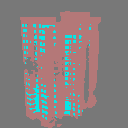

In [ ]:

with torch.no_grad():
    scores = seg_module(singleton_batch, segSize=output_size)
# Get the predicted scores for each pixel
_, pred = torch.max(scores, dim=1)
pred = pred.cpu()[0].numpy()
visualize_result(img_original, pred)

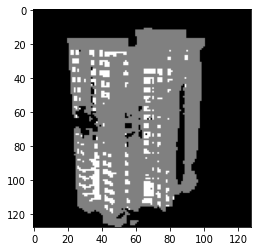

In [ ]:
plt.imshow(pred, cmap=plt.cm.gray)

In [ ]:
numpy.unique(pred)

array([0, 1, 2])

In [ ]:
687_1.3357763+103.6950631_temp_64_72_-79_41_54_54_9_02_3_55_29_01.jpg